## Precondition

In [1]:
! pip install scipy==1.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [9]:
from collections import Counter
import matplotlib.pyplot as plt
from zlib import adler32
from scipy import stats
import networkx as nx
import pandas as pd
import scipy as sp
import numpy as np
import requests
import ast

## Функции оценки результатов

In [121]:
def score(true, pred, sigma):
  res = np.exp(-(true - pred) ** 2 / (2 * sigma ** 2))
  return round(res, 4)

In [167]:
def take_hw_score(result):
    keys = ['radius', 'diameter', 'average_clustering', 'average_path_length', 'number_cc']
    S = 0
    for key in keys:
      value, sigma = conditions[key]
      s = score(value, result[key], sigma)
      print(f"{key}: {s * 100}")
      S += 1 / 6 * s 
    print(f"END: {S * 100}")


In [168]:
take_hw_score(result)

radius: 100.0
diameter: 96.92
average_clustering: 90.41
average_path_length: 88.07000000000001
number_cc: 100.0
END: 79.23333333333332


## 1. Task

Challenge Overview
Your goal is to generate an undirected network that is as close as possible to the original real network. You do not have the original network in the explicit view, but you know some of its statistics. All statistics are in stats.txt file that contains a dictionary of the form
* number_nodes (number of nodes): value
* number_cc (number of connected components): value, sigma
* radius (radius of giant component): value, sigma
* diameter (diameter of giant component): value, sigma
* average_clustering (average clustering coefficient): value, sigma
* average_path_length (average path length): value, sigma
*degree_cdf (empirical CDF of degree distribution): values, probabilities

Meaning of all these sigmas is described in Evaluation section. 

You can use this code to draw CDF


In [10]:
"""
q_seq, p_seq = stats['degree_cdf']
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
    np.repeat(p_seq, 2)
)
plt.show()
"""

"\nq_seq, p_seq = stats['degree_cdf']\nplt.plot(\n    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), \n    np.repeat(p_seq, 2)\n)\nplt.show()\n"

In [3]:
conditions = {
  "number_nodes": 1882,
  "radius": [15, 2],
  "diameter": [28, 4],
  "average_clustering": [0.005066798238955518, 0.001],
  "average_path_length": [11.748410823170731, 2],
  "number_cc": [168, 32],
  "degree_cdf": [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 46],
                 [0.0, 0.6902231668437833, 0.8517534537725824, 0.9086078639744952, 0.9378320935175345, 0.9516471838469713, 0.9654622741764081, 0.9723698193411264, 0.9776833156216791, 0.9808714133900106, 0.9845908607863975, 0.9888416578108395, 0.9893730074388948, 0.9925611052072264, 0.9936238044633369, 0.9952178533475027, 0.9957492029755579, 0.9968119022316685, 0.997874601487779, 0.9989373007438895, 0.9994686503719448, 1.0]]}

In [4]:
NUM_NODES = 1882

### 1.1 CDF Эталонного графа

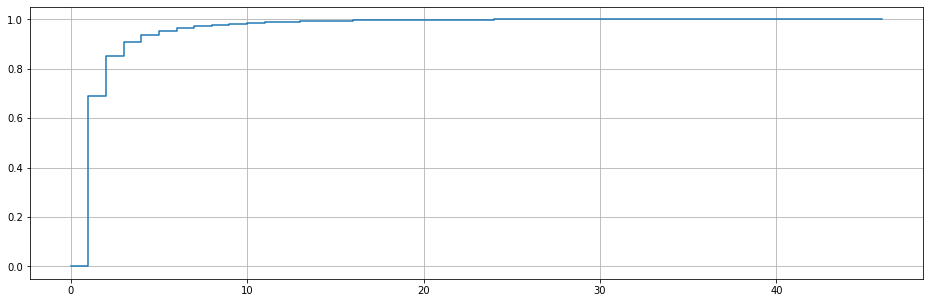

In [11]:
plt.figure(figsize=(16, 5))
q_seq, p_seq = conditions['degree_cdf']
q_seq = np.array(q_seq)
p_seq = np.array(p_seq)
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
    np.repeat(p_seq, 2)
)
plt.grid()
plt.show()

### 1.2 PPF Эталонного графа

In [12]:
ppf = [0]
for i in range(len(p_seq) - 1):
  diff = p_seq[i + 1] - p_seq[i]
  ppf.append(diff)
ppf = np.array(ppf)

def power_law_ppf(ppf):
    return np.random.choice(a=q_seq, replace=True, p=ppf)

In [13]:
while True:
  d_dist = np.random.choice(a=q_seq, replace=True, size=NUM_NODES, p=ppf)
  hist = list(Counter(sorted(d_dist)).values())
  hist.insert(0, 0)
  cdf = np.cumsum(hist) / np.sum(hist)
  stat, p = stats.kstest(rvs=cdf, cdf=p_seq)
  if 1 - stat > 0.93:
    break

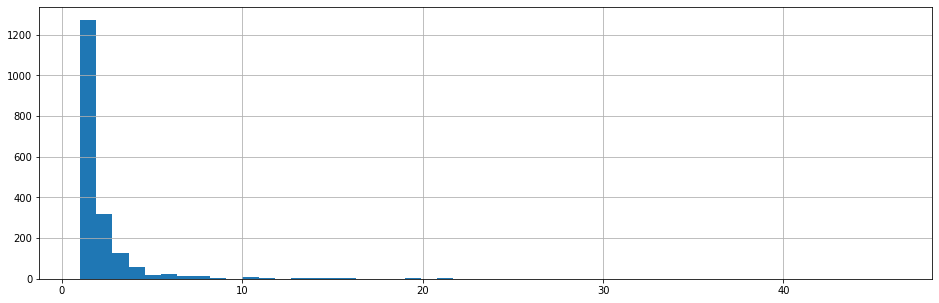

In [14]:
plt.figure(figsize=(16, 5))
plt.hist(d_dist, bins=50)
plt.grid()

## 2. Generate graph (Erdos-Renyi model)

### Расчет параметров для генерации, поиск вероятности

In [15]:
print(f"Существующие степени вершин: {q_seq}")
num_degrees = np.array([round(x * NUM_NODES) for x in ppf])
assert sum(num_degrees) == NUM_NODES
print(f"Количество вершин каждой степени: {num_degrees}")
NUM_EDGES = np.sum(num_degrees * q_seq) // 2
print(f"Количество ребер: {NUM_EDGES}")

Существующие степени вершин: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 24 46]
Количество вершин каждой степени: [   0 1299  304  107   55   26   26   13   10    6    7    8    1    6
    2    3    1    2    2    2    1    1]
Количество ребер: 1740


In [16]:
p = NUM_EDGES / (NUM_NODES * (NUM_NODES - 1)) * 2
print(f"Вероятность: {p}")

Вероятность: 0.0009830391842808644


### Генерирование графа 

In [17]:
%%time
G = nx.erdos_renyi_graph(NUM_NODES, p)

CPU times: user 495 ms, sys: 1.33 ms, total: 496 ms
Wall time: 505 ms


### Распределение степеней сгенерированного графа

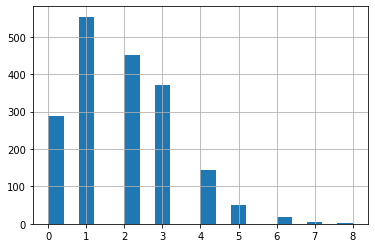

In [18]:
deg_dist = dict(G.degree)
plt.hist(list(deg_dist.values()), bins=20)
plt.grid()

In [19]:
conn_comps = list(nx.connected_components(G))
largest_cc = max(conn_comps, key=len)
subG = G.subgraph(largest_cc)
print(f"Количество компонент связности: {len(conn_comps)}")
print(f"Количество узлов в огромной компоненте: {subG.number_of_nodes()}")

Количество компонент связности: 353
Количество узлов в огромной компоненте: 1438


### Все статистика графа

In [20]:
def get_all_stats(G):
  result = {}
  conn_comps = list(nx.connected_components(G))
  largest_cc = max(conn_comps, key=len)
  subG = G.subgraph(largest_cc)
  result['radius'] = nx.radius(subG)
  result['diameter'] = nx.diameter(subG)
  result['average_clustering'] = nx.average_clustering(G)
  result['average_path_length'] = nx.average_shortest_path_length(subG)
  result['number_cc'] = len(conn_comps)
  return result

In [21]:
result = get_all_stats(G)
result 

{'radius': 15,
 'diameter': 27,
 'average_clustering': 0.00020241890592581345,
 'average_path_length': 10.740154645311716,
 'number_cc': 353}

### Отрисовать компоненты связности

In [31]:
# subG сгенерированный граф
# subG_big самая большая компонента
# subG_small остальные маленькие компоненты

copyG = G.copy()
conn_comps = list(nx.connected_components(G))
largest_cc = max(conn_comps, key=len)
copyG_big = G.subgraph(largest_cc)

copyG_small = G.copy()
copyG_small.remove_nodes_from(largest_cc)

len(conn_comps)
print(f"Весь граф: кол-во нод {copyG.number_of_nodes()}, кол-во компонент {len(conn_comps)}")
print(f"Огромная компонента: кол-во нод {copyG_big.number_of_nodes()}, кол-во компонент {len(list(nx.connected_components(copyG_big)))}")
print(f"Маленькие компоненты: кол-во нод {copyG_small.number_of_nodes()}, кол-во компонент {len(list(nx.connected_components(copyG_small)))}")

Весь граф: кол-во нод 1882, кол-во компонент 353
Огромная компонента: кол-во нод 1438, кол-во компонент 1
Маленькие компоненты: кол-во нод 444, кол-во компонент 352


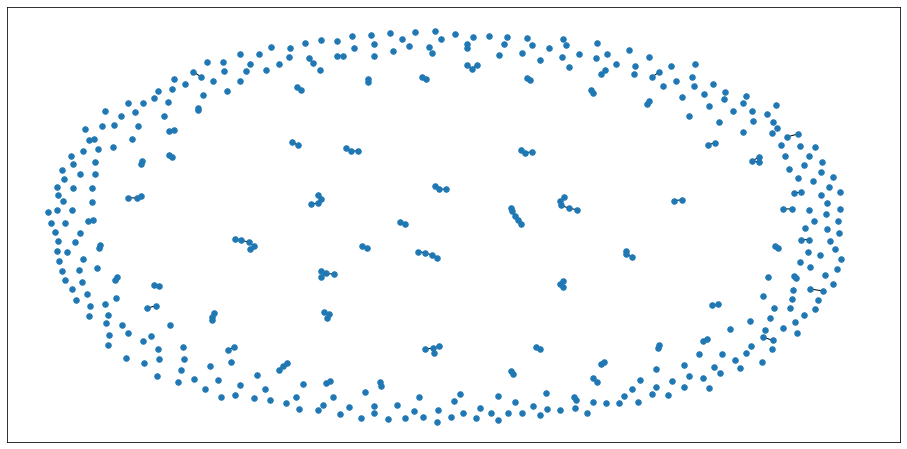

In [32]:
plt.figure(figsize=(16, 8))
nx.draw_networkx(copyG_small, with_labels=False, node_size=30)

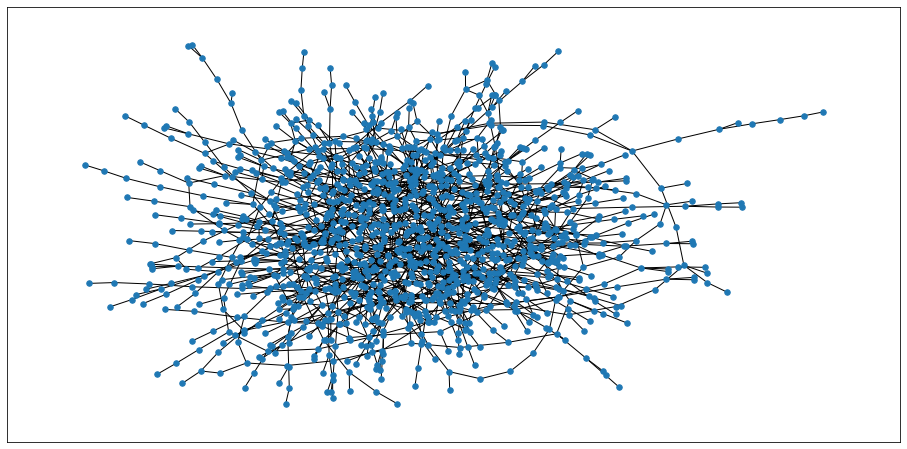

In [33]:
plt.figure(figsize=(16, 8))
nx.draw_networkx(copyG_big, with_labels=False, node_size=30)

## Изменение графа

In [88]:
copyG = G.copy()
nodes = list(copyG_small.nodes)

### Добавим треугольники и двойки для регулирования коэффиценка кластеризации и количества компонент связности

In [118]:
best_diff_clust = 1
for div_coef in range(4, 40):
    copyG = G.copy()
    nodes = list(copyG_small.nodes)
    
    # делаем треугольники
    for i in range(0, div_coef - 3, 3):
      copyG.add_edge(nodes[i], nodes[i + 1])
      copyG.add_edge(nodes[i + 1], nodes[i + 2])
      copyG.add_edge(nodes[i], nodes[i + 2])
    diff = abs(nx.average_clustering(copyG)-conditions["average_clustering"][0])
    #print(f"\n diff:{diff}")
    #print(f"average_clustering: {nx.average_clustering(copyG)}")
    if  diff < best_diff_clust:
      best_diff_clust = diff
      bestG = copyG.copy()

print(f"Количество компонент связности: {len(list(nx.connected_components(bestG)))}")
print(f"Average_clustering: {nx.average_clustering(bestG)}")

Количество компонент связности: 345
Average_clustering: 0.005515915186478417


In [120]:
zero_nodes = [n[0] for n in dict(bestG.degree()).items() if n[1]==0]
#делаем двойки
if len(zero_nodes)%2:
  print("нечетное количество, соединяем первую и последнюю нулевую ноду")
  bestG.add_edge(zero_nodes[0], zero_nodes[-1])
for i in range(0, len(zero_nodes) - 2, 2):
  bestG.add_edge(zero_nodes[i], zero_nodes[i + 1])

print(f"Количество компонент связности: {len(list(nx.connected_components(bestG)))}")
print(f"Average_clustering: {nx.average_clustering(bestG)}")

Количество компонент связности: 205
Average_clustering: 0.005515915186478417


In [132]:
%%time
result = get_all_stats(bestG)
result 

CPU times: user 37 s, sys: 88.3 ms, total: 37.1 s
Wall time: 37.5 s


{'radius': 15,
 'diameter': 27,
 'average_clustering': 0.005515915186478417,
 'average_path_length': 10.740154645311716,
 'number_cc': 205}

### 1вариант Соеденим двойки в цепочки для уменьшения количества компонент (у меня получилось их 205, а нужно 168)

In [135]:
copyBestG = bestG.copy()
copyBestG_small = copyBestG.copy()
copyBestG_small.remove_nodes_from(max(list(nx.connected_components(copyBestG)), key=len))

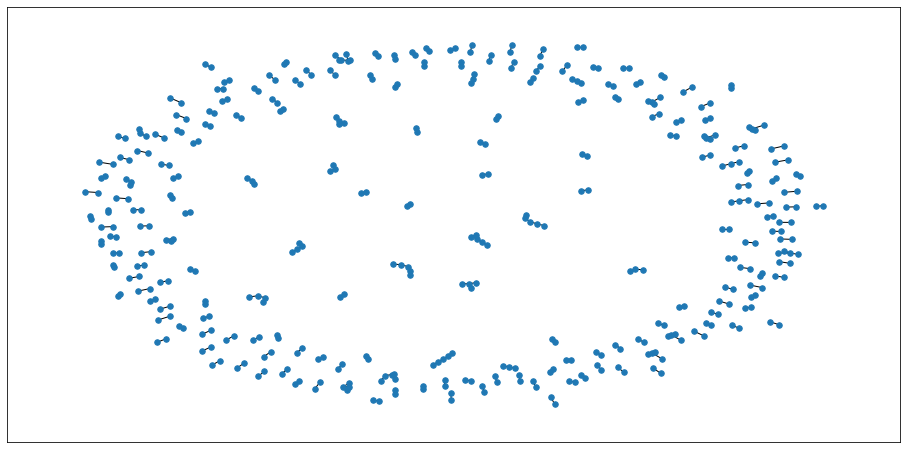

In [136]:
plt.figure(figsize=(16, 8))
nx.draw_networkx(copyBestG_small, with_labels=False, node_size=30)

In [157]:
doubles_components = [list(c) for c in list(nx.connected_components(copyBestG)) if len(c)==2]
component_diff = len(list(nx.connected_components(bestG)))-conditions["number_cc"][0]
for i in range(0, component_diff*2, 2):
    copyBestG.add_edge(doubles_components[i][0], doubles_components[i+1][0])

print(f"Количество компонент связности: {len(list(nx.connected_components(copyBestG)))}")
print(f"Average_clustering: {nx.average_clustering(copyBestG)}")

In [160]:
%%time
result = get_all_stats(copyBestG)
result 

CPU times: user 35 s, sys: 83.5 ms, total: 35.1 s
Wall time: 35.5 s


{'radius': 15,
 'diameter': 27,
 'average_clustering': 0.005515915186478417,
 'average_path_length': 10.740154645311716,
 'number_cc': 168}

### 2 вариант. Частично соеденить двойки с тройками для уменьшения компоненты связности и увеличения среднего пути

In [232]:
copyBestG_2 = bestG.copy()
copyBestG_small_2 = copyBestG_2.copy()
copyBestG_small_2.remove_nodes_from(max(list(nx.connected_components(copyBestG_2)), key=len))

doubles_components = [list(c) for c in list(nx.connected_components(copyBestG_small_2)) if len(c)==2]
moreThenDouble_components= [list(c) for c in list(nx.connected_components(copyBestG_small_2)) if len(c)>2]


component_diff = len(list(nx.connected_components(bestG)))-conditions["number_cc"][0]

connection_coef = 0.95 #кол-во соединений дупл дупл

#соединения дуплетов с дуплетами
for i in range(0, int(component_diff*connection_coef)*2, 2):
    copyBestG_2.add_edge(doubles_components[i][0], doubles_components[i+1][0])

doubles_components_new = doubles_components[int(component_diff*connection_coef)*2:]
#соединения дуплетов с треплетами
for i in range(0, component_diff - int(component_diff*connection_coef)):
    copyBestG_2.add_edge(doubles_components_new[i][0], moreThenDouble_components[i][0])

print(f"количество соединений дупл дупл: {int(component_diff*connection_coef)}")
print(f"количество соединений дупл трипл: {component_diff - int(component_diff*connection_coef)}")
print()
print(f"Количество компонент связности: {len(list(nx.connected_components(copyBestG_2)))}")
print(f"Average_clustering: {nx.average_clustering(copyBestG_2)}")

количество соединений дупл дупл: 35
количество соединений дупл трипл: 2
Количество компонент связности: 168
Average_clustering: 0.005161682101108242


In [272]:
%%time
result = get_all_stats(copyBestG_2)
result 

KeyboardInterrupt: ignored

In [234]:
take_hw_score(result)

radius: 100.0
diameter: 96.92
average_clustering: 99.55000000000001
average_path_length: 88.07000000000001
number_cc: 100.0
END: 80.75666666666666


### 3 вариант Добьем параметр использовав вершины одноо дуплета и соеденив его с гигантской компонентой нужым образос

In [240]:
copyBestG_2 = bestG.copy()
copyBestG_small_2 = copyBestG_2.copy()
copyBestG_small_2.remove_nodes_from(max(list(nx.connected_components(copyBestG_2)), key=len))

doubles_components = [list(c) for c in list(nx.connected_components(copyBestG_small_2)) if len(c)==2]
moreThenDouble_components= [list(c) for c in list(nx.connected_components(copyBestG_small_2)) if len(c)>2]


component_diff = len(list(nx.connected_components(bestG)))-conditions["number_cc"][0]

connection_coef = 0.95 #кол-во соединений дупл дупл

# во варианте 2 разбиение 35 на 2. сейчас сделаем 34 на 2 и еще 1 компоненту
# соеденим с максимальной компонентой для получения диаметра 2, увеличения среднего пути 

#соединения дуплетов с дуплетами
for i in range(0, int(component_diff*connection_coef)*2 -2, 2):
    copyBestG_2.add_edge(doubles_components[i][0], doubles_components[i+1][0])

doubles_components_new = doubles_components[int(component_diff*connection_coef)*2:]
#соединения дуплетов с треплетами
for i in range(0, component_diff - int(component_diff*connection_coef)):
    copyBestG_2.add_edge(doubles_components_new[i][0], moreThenDouble_components[i][0])

print(f"количество соединений дупл дупл: {int(component_diff*connection_coef)}")
print(f"количество соединений дупл трипл: {component_diff - int(component_diff*connection_coef)}")
print()
print(f"Количество компонент связности: {len(list(nx.connected_components(copyBestG_2)))}")
print(f"Average_clustering: {nx.average_clustering(copyBestG_2)}")

количество соединений дупл дупл: 35
количество соединений дупл трипл: 2

Количество компонент связности: 169
Average_clustering: 0.005161682101108242


In [244]:
double = [list(c) for c in list(nx.connected_components(copyBestG)) if len(c)==2][0]
#находим конечные ноды со степенью 1 в гигантской компоненте 
#которые максимально отдалены и соединяем к нему наш дуплет
copyBestG_big_2 = copyBestG_2.subgraph(max(list(nx.connected_components(copyBestG_2)), key=len))
oneK_nodes = [n[0] for n in dict(copyBestG_big_2.degree()).items() if n[1]==1]
oneK_nodes_sort = [i for i in nx.closeness_centrality(copyBestG_big_2).items() if i[0] in oneK_nodes]
oneK_nodes_sort = sorted(oneK_nodes_sort, key = lambda i: i[1])

In [270]:
#смотрим параметры и выбираем лучшее

loop_oneK_nodes = oneK_nodes_sort[:3]
for i in loop_oneK_nodes:
    loopG = copyBestG_2.copy()
    #Удаляем связь дупл
    loopG.remove_edge(double[0], double[1])
    #одну соединяем с интересующей нас нодой вторую просто к другой дальней
    loopG.add_edge(double[0], i[0])
    loopG.add_edge(double[1], oneK_nodes_sort[4][0])

    largest_cc = max(list(nx.connected_components(loopG)), key=len)
    loopG_big = loopG.subgraph(largest_cc)

    
    print(f"Average_clustering: {nx.average_clustering(loopG)}")
    print(f"diameter: {nx.diameter(loopG_big)}")
    print(f"radius: {nx.radius(loopG_big)}")
    print(f"average_path: {nx.average_shortest_path_length(loopG_big)}")
    print()

Average_clustering: 0.005161682101108242
diameter: 28
radius: 15
average_path: 10.762005829665663
Average_clustering: 0.005161682101108242
diameter: 28
radius: 15
average_path: 10.759278241062466
Average_clustering: 0.005161682101108242
diameter: 28
radius: 15
average_path: 10.759278241062466


In [273]:
#Приходим к выводу что нужно соединять с самой первой
copyBestG_3 = copyBestG_2.copy()
#удаляем связь дупл
copyBestG_3.remove_edge(double[0], double[1])
#одну соединяем с интересующей нас нодой вторую просто к другой дальней
copyBestG_3.add_edge(double[0], oneK_nodes_sort[0][0])
copyBestG_3.add_edge(double[1], oneK_nodes_sort[4][0])

In [274]:
%%time
result = get_all_stats(copyBestG_3)
result 

CPU times: user 37.2 s, sys: 102 ms, total: 37.3 s
Wall time: 37.6 s


{'radius': 15,
 'diameter': 28,
 'average_clustering': 0.005161682101108242,
 'average_path_length': 10.762005829665663,
 'number_cc': 168}

In [275]:
take_hw_score(result)

radius: 100.0
diameter: 100.0
average_clustering: 99.55000000000001
average_path_length: 88.55
number_cc: 100.0
END: 81.35


## Запись файла ответа

In [236]:
def write_graph(G, filename):
    b = []
    for a in list(G.edges()):
      b.append(a[0])
      b.append(a[1])
    assert len(set(b)) == 1882
    with open(filename, "w") as file:
        for e in G.edges():
            file.write(f"{e[0]} {e[1]}\n")

In [276]:
write_graph(copyBestG_3, "copyBestG_3.txt")